### （完成版で予定している）前提条件

・対数正規分布に従うような「企業価値」の変動（株式市場にとっては外生的な変動）

・「企業価値」に比例した「均衡」株価

・１エージェントが採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは各エージェントごとに独自に振動する。収益率の低いエージェントほど他エージェントの真似をして戦略やパラメータを変更する傾向を持つ。

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ

・配当（企業価値の一定割合）と税（利益の一定割合）と非金融所得（外生的、一定、全エージェント）の導入

・時間１が四半期あるいは１年程度のスパンをイメージする


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [39]:
using StatsPlots
using Random
using Statistics

In [40]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオに占める預金の割合の目標, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオに占める預金の割合の目標, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    purchase_cost
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業価値
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms)
    σ_r, σ, μ = 0.05, 2.0, log(100.0)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.05*firms[i].hiddenCorporateValue + 0.95*estimated_value) * exp(0.1*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j, all_marketCap_sum)
    lst = []
    marketCap, mean_log10e_amp, fundamentals_sum = 0.0, 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        fundamentals = agent.fundamentals[i]
        push!(lst, (marketCap/fundamentals, i))    #   marketCap/fundamentalsが小さいほど買いたい、大きいほど売りたい
        mean_log10e_amp += log(50ℯ ,marketCap/fundamentals)    #   底をℯにすると、mean_log10e_ampが乱高下する。底が大きいものを採用した。
        fundamentals_sum += fundamentals
    end
    mean_log10e_amp /= size(firms)[1]
    sell, buy = [], []
    #   全部売り候補に入れて、ポートフォリオ配分目標に至るまで買い候補に入れて、その差額を本チャンの売買リストに加える
    #   すべて仮売り。
    marketCap_sum = 0.0
    for (i,q) in enumerate(agent.sharesQuantity)
        if q > 0.0
            marketCap_sum = firms[i].marketCapitalization
        end
    end
    for (i,q) in enumerate(agent.sharesQuantity)
        if q > 0.0
            if rand() < sqrt(firms[i].marketCapitalization/marketCap_sum)
                p = min(firms[i].stockPrice, (0.2*exp(mean_log10e_amp)*agent.fundamentals[i]/firms[i].stockQuantity + 0.8*firms[i].stockPrice))
                push!(sell, (i, p, q))
            end
        end
    end
    #   仮買い。
    sort!(lst)
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    counter = 0
    for k in 1:size(lst)[1]
        _, i = lst[k]
        if rand() < sqrt(firms[i].marketCapitalization/all_marketCap_sum)   #   規模の大きい企業ほど売買の対象になりやすいようにする
            allocations_lst[i] = agent.portfolio_target[2]*agent.fundamentals[i]/fundamentals_sum
            counter += 1
            if counter == Integer(agent.params[end])
                break
            end
        end
    end
    for k in 1:size(lst)[1]
        _, i = lst[k]
        if allocations_lst[i] == 0.0
            continue
        end
        p = (0.2*exp(mean_log10e_amp)*agent.fundamentals[i] + 0.8*firms[i].marketCapitalization)/(firms[i].stockQuantity)
        q = allocations_lst[i]/p
        push!(buy, (i, p, q))
    end
    #   注文の決定
    going_to_buy_price = 0.0
    for (ib, pb, qb) in sell
        q, p = qb, pb
        for (is, ps, qs) in buy
            if ib == is
                q -= qs
                if q < 0.0
                    p = ps
                end
                break
            end
        end
        if q > 0
            push!(firms[ib].sell_offers, (p, q, j))
        elseif q < 0
            going_to_buy_price += p*(-q)
            if going_to_buy_price > agent.money
                continue
            end
            push!(firms[ib].buy_offers, (p, -q, j))
        end
    end
end
function chart_trade_offer(agent, firms, j, all_marketCap_sum)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    #   売り
    for (i, q) in enumerate(agent.sharesQuantity)
        if q == 0.0
            continue
        end
        x1, x2, x3, x4, x5, x6 = firms[i].stockPriceLog[end-5:end]
        p = α0 + α1*(x2-x1)/x1 + α2*(x3-x2)/x2 + α3*(x4-x3)/x3 + α4*(x5-x4)/x4 + α5*(x6-x5)/x5
        if p < β1
            push!(sell, (p,i))
        end
    end
    marketCap_sum = 0.0
    sell_2 = []
    for (p, i) in sell
        if agent.money < 0.0
            p = 0.0
        end
        price = (1+p)*firms[i].stockPrice
        quantity = agent.sharesQuantity[i]
        if price <= 0.0 || quantity == 0.0
            continue
        else
            push!(sell_2, (p, i))
        end
        marketCap_sum += firms[i].marketCapitalization
    end
    going_to_sell_price = 0.0
    for (p, i) in sell_2
        if agent.money < 0.0
            p = 0.0
        end
        price = (1+p)*firms[i].stockPrice
        quantity = agent.sharesQuantity[i]
        if rand() < sqrt(firms[i].marketCapitalization/marketCap_sum)
            going_to_sell_price += price * quantity
            push!(firms[i].sell_offers, (price, quantity, j))
        end
    end
    #   買い
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = α0 + α1*(x2-x1)/x1 + α2*(x3-x2)/x2 + α3*(x4-x3)/x3 + α4*(x5-x4)/x4 + α5*(x6-x5)/x5
        if p > β2
            if rand() < sqrt(firm.marketCapitalization/all_marketCap_sum)
                push!(buy, (p,i))
            end
        end
    end
    sort!(buy)
    if size(buy)[1] > Integer(agent.params[end])
        buy = buy[end-Integer(agent.params[end])+1:end]
    end
    marketCap_sum = 0.0
    for (_, i) in buy
        marketCap_sum += firms[i].marketCapitalization
    end
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    buy_target = agent.money + going_to_sell_price - agent.portfolio_target[1]
    if buy_target <= 0.0
        return nothing
    end
    for (_, i) in buy
        allocations_lst[i] = buy_target*firms[i].marketCapitalization/marketCap_sum
    end
    for (p, i) in buy
        price = (1+p)*firms[i].stockPrice
        if price <= 0.0
            continue
        end
        quantity = allocations_lst[i]/price
        push!(firms[i].buy_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms, all_marketCap_sum)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j, all_marketCap_sum)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j, all_marketCap_sum)
        end
    end
end
function cal_performance(agents, income)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1] - income)/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].purchase_cost[i] = (agents[jb].purchase_cost[i]*agents[jb].sharesQuantity[i] + trading_p*trading_q)/(agents[jb].sharesQuantity[i] + trading_q)
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            tax, tax_rate = 0.0, 0.2
            if agents[js].purchase_cost[i] < trading_p
                tax = tax_rate*trading_q*(trading_p - agents[js].purchase_cost[i])
            end
            agents[js].money += trading_p*trading_q - tax
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    A = Integer(size(agents)[1])
    for agent in agents
        teacher = rand(1:A)
        t0, t1 = agent.total_assets_log[end-9], agent.total_assets_log[end]
        if rand() < 0.01 - 0.01*(t1 - t0)/t0
            new_strategy = deepcopy(agents[teacher].strategy)
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[3:7] = (agent.params[3:7] .- sum(agent.params[3:7])/5)/(std(agent.params[3:7])*sqrt(5))
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function get_income(agents, income)
    for agent in agents
        agent.money += income
    end
end
function get_dividend(agents, firms)
    Π = 0.2
    payout_ratio = 0.35
    for agent in agents
        for (i, q) in enumerate(agent.sharesQuantity)
            if q > 0.0
                dividend = q/firms[i].stockQuantity * Π*payout_ratio*firms[i].hiddenCorporateValue
                agent.money += dividend
            end
        end
    end
end
function cal_all_marketCap_sum(firms)
    all_marketCap_sum = 0.0
    for firm in firms
        all_marketCap_sum += firm.marketCapitalization
    end
    return all_marketCap_sum
end
function run_one_term(agents, firms, income)
    all_marketCap_sum = cal_all_marketCap_sum(firms)
    update_hiddenCorporateValue(firms)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms, all_marketCap_sum)
    trade_matching(agents, firms)
    get_dividend(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents, income)
    get_income(agents, income)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end
function f(t)
    return 2^(0.01*t)
end

f (generic function with 1 method)

In [41]:
N, M = 10^2, 10^1 #   エージェント数, 株式会社数
init_stock_quantity, init_stock_price = 100.0, 1.0
init_money = init_stock_quantity*init_stock_price*M/N * 9.0

agents = [
    Agent(
        "chart",
        init_money,
        [init_stock_quantity/N for _ = 1:M],
        [init_stock_quantity*init_stock_price/N for _ = 1:M],
        [init_money/0.9],
        [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, 0.1*init_money],
        [1.0 for _ = 1:M],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [init_stock_quantity/N for _ = 1:M],
            [init_stock_quantity*init_stock_price/N for _ = 1:M],
            [init_money/0.9],
            [0.9, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, 0.1*init_money],
            [1.0 for _ = 1:M],
            0.0
        )
    )
end

σ_r, σ, μ = 0.2, 2.0, log(100.0)
σ_p = sqrt(σ^2 + σ_r^2)
x = [μ for _ = 1:M]
for t = 1:10^3
    for i = 1:M
        x[i] = exp((log(x[i]) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
firms = [
    Firm(
        init_stock_price,
        init_stock_quantity,
        [init_stock_price],
        [init_stock_quantity],
        init_stock_price*init_stock_quantity,
        x[i],   #   元init_stock_price*init_stock_quantity
        [],
        [],
    ) for i = 1:M
];

In [42]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

9000.0

In [43]:
T = 10^4
income_lst = [0.0002*init_money for _ = 1:T]
#income_lst = [0.0002*init_money*f(t) for t = 1:T] 
#   income=constantだと、金融市場の規模が継続的に大きく（小さく）ならないためか、
#   適応の結果ポートフォリオ配分目標に占める預金の割合がとても大きくなる。そして売買が減り、値動きが激減する
@time for t = 1:T
    income = income_lst[t]
    run_one_term(agents, firms, income)
    if t % (T//100) == 0
        print("#")
    end
    if t % (T//10) == 0
        println()
    end
end

##########
##########
##########
##########
##########
##########
##########
##########
##########
##########
 89.938476 seconds (840.76 M allocations: 18.840 GiB, 4.24% gc time, 1.71% compilation time)


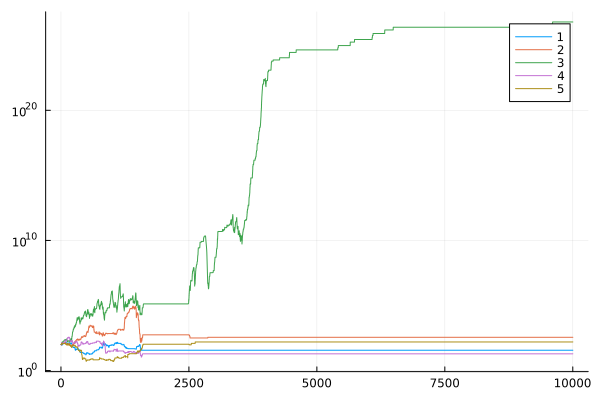

In [44]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog.*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog.*firms[5].stockQuantityLog, label=string(5), yscale=:log10)

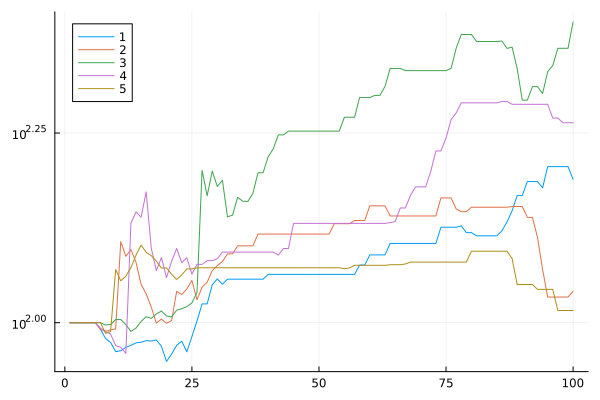

In [45]:
plot(firms[1].stockPriceLog[1:100].*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[1:100].*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[1:100].*firms[5].stockQuantityLog, label=string(5), yscale=:log10)

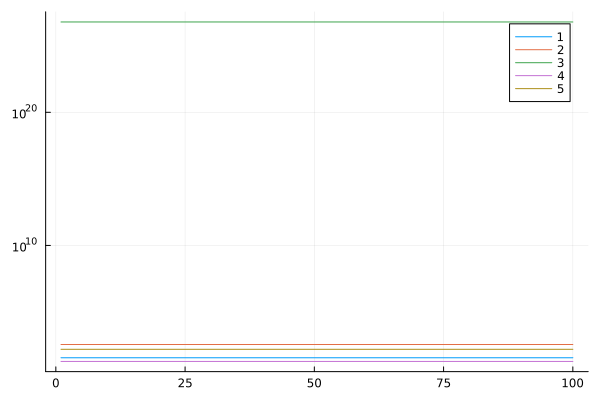

In [46]:
plot(firms[1].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(5), yscale=:log10)

・企業価値/時価総額が相対的に大きいときは、fundamental戦略をとるエージェントが売買の中心になっていて、価格変動が安定しやすい

・企業価値/時価総額が相対的に小さいときは、chart戦略をとるエージェントが売買の中心になっていて、価格変動が変動しやすい

かもしれない

In [47]:
tmp = 0.0
for i = 1:10
    for t = 1:99
        tmp += 100*(firms[i].stockPriceLog[end-t] - firms[i].stockPriceLog[end-1-t])/firms[i].stockPriceLog[end-1-t]
    end
    tmp /= 99
    println("「会社$i","の直近１００期の株価の平均変動率」は $tmp"," %")
end

「会社1の直近１００期の株価の平均変動率」は 0.0 %
「会社2の直近１００期の株価の平均変動率」は 0.0 %
「会社3の直近１００期の株価の平均変動率」は 0.0 %
「会社4の直近１００期の株価の平均変動率」は 0.0 %
「会社5の直近１００期の株価の平均変動率」は 0.0 %
「会社6の直近１００期の株価の平均変動率」は 0.0 %
「会社7の直近１００期の株価の平均変動率」は 0.0 %
「会社8の直近１００期の株価の平均変動率」は 0.0 %
「会社9の直近１００期の株価の平均変動率」は 0.0 %
「会社10の直近１００期の株価の平均変動率」は 0.0 %


In [48]:
for i = 1:10
    println(agents[i].portfolio_target[2], " / ", sum(agents[i].sharesRetainedLine))
end#    ポートフォリオ配分が目標との乖離が激しい問題。

4.1716539762148084e24 / 4.581665264289972e24
1.0266557020803317e11 / 4.601135676585667e11
2.5199020185383193e12 / 2.740197025780487e12
1.1728018923969571e24 / 1.8244397046130137e24
8.11511948535733e24 / 1.2999083941585616e26
1.20802914112996e12 / 6.341637521545189e12
2.6636227266249725e15 / 5.540586891448934e15
8.98241465162037e23 / 1.772622360517379e24
3.826881335346567e16 / 6.447690710305305e16
1.393955785913861e23 / 1.560449112411704e23


In [49]:
agents

100-element Vector{Agent}:
 Agent("chart", -2.7013285788694664e16, [0.0, 0.12880337587544657, 0.7529916707975162, 0.0, 0.0, 14.12497350014581, 0.0, 6.2272772611470515, 0.0, 6.972266297504571], [0.0, 0.46557361002525965, 4.5816652310692337e24, 0.0, 0.0, 775.4372812038282, 0.0, 0.0950697364680807, 0.0, 3.3220738234972348e16], [100.0, 108.07394813901826, 115.8526247333402, 124.00279534063714, 132.0169056065035, 141.64488938895101, 148.56183541659888, 149.19605792623477, 152.0583568965844, 155.44529022851944  …  4.581665237276686e24, 4.581665237276686e24, 4.581665237276686e24, 4.581665237276686e24, 4.581665237276686e24, 4.581665237276686e24, 4.581665237276686e24, 4.581665237276686e24, 4.581665237276686e24, 4.581665237276686e24], [0.08948957198487639, 8.0, -0.42055887380889023, 0.573536352225775, -0.47497473764059417, 0.252497721043431, 0.06949953818027844, -0.07999197949908492, 0.21639380023732357, 1.393098494942466, 0.7615236933989987, 99.0], [97.37980405542979, 416.17626462632177, 125.59

In [50]:
firms

10-element Vector{Firm}:
 Firm(0.3666463523144038, 100.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9808108078541145, 0.9533702077519507, 0.9418299391269116, 0.9158197988113026  …  0.3666463523144038, 0.3666463523144038, 0.3666463523144038, 0.3666463523144038, 0.3666463523144038, 0.3666463523144038, 0.3666463523144038, 0.3666463523144038, 0.3666463523144038, 0.3666463523144038], [100.0], 36.66463523144038, 106.93615807184844, Any[], Any[])
 Firm(3.614607201564898, 100.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9796931704910408, 0.9744438040068091, 0.9786188361812973, 0.9813150862363308  …  3.614607201564898, 3.614607201564898, 3.614607201564898, 3.614607201564898, 3.614607201564898, 3.614607201564898, 3.614607201564898, 3.614607201564898, 3.614607201564898, 3.614607201564898], [100.0], 361.4607201564898, 191.7566920220634, Any[], Any[])
 Firm(6.084616083756483e24, 100.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9928904545488368, 0.9946839179535316, 1.009518604370283  …  6.084616083756483e24, 6.0846160837

In [51]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

-2.4278911204874336e16

In [52]:
for firm in firms[1:10]
    println(firm.hiddenCorporateValue)
end

106.93615807184844
191.7566920220634
78.4355545102249
111.86421736574417
1.0908818526931854
423.2731873610953
71.33751050484402
2481.400641246417
16.322366934676786
1752.2432624461867


In [53]:
for firm in firms[1:10]
    println(firm.marketCapitalization)
end

36.66463523144038
361.4607201564898
6.084616083756483e26
19.36763099577258
158.60018335977503
5489.831759300812
17.871134230607378
1.526666189431383
1253.4273362630138
4.764697275957792e17


In [54]:
for agent in agents[1:10]
    println(agent.fundamentals)
end

[97.37980405542979, 416.17626462632177, 125.59334191491119, 364.9415350616331, 1.1570472602341124, 290.18460881178834, 194.35283964840346, 3457.8657150293097, 24.805497139960227, 3001.997086223895]
[245.8085906446017, 161.47191928296448, 45.12423424634461, 141.92871076070017, 1.1066390516889626, 406.1989273112796, 106.64341231464084, 1071.3914523526735, 15.146524670299485, 1070.4091420613104]
[138.48173215173992, 220.61032832955846, 79.62874320109697, 123.81575294572555, 1.6836337399344654, 517.3037708175165, 113.85049013769438, 2408.734365161642, 14.959762894805309, 3011.4178710475376]
[177.88805586274805, 330.3461400777888, 72.74188645206446, 268.89147889109233, 1.3039106359277992, 340.8388186597461, 81.16713591900184, 1628.7871163260927, 15.731647574534328, 1337.66065361459]
[170.53058096453097, 243.87733758702694, 120.0535499535112, 236.77377630805057, 0.8749010761163534, 720.9358635706428, 52.16377023952585, 1830.0747464449055, 14.733416410652632, 1727.5287929891333]
[95.896422099

In [55]:
for agent in agents[1:10]
    println(agent.params)
end

[0.08948957198487639, 8.0, -0.42055887380889023, 0.573536352225775, -0.47497473764059417, 0.252497721043431, 0.06949953818027844, -0.07999197949908492, 0.21639380023732357, 1.393098494942466, 0.7615236933989987, 99.0]
[0.7768690132694501, 5.0, -0.5161218354208085, 0.7012813342062038, -0.193656429591341, 0.050529291115118294, -0.042032360309172505, 0.09080363892250873, 0.24834418129362776, 1.4576169035519262, 0.5911794102992962, 98.0]
[0.08177811899957774, 4.0, -0.47680901521937974, 0.666251707697472, -0.07568047904300092, 0.18453489263287423, -0.2982971060679655, 0.2626503193608212, 0.1405665077183074, 1.4656286738057558, 0.4634359243046042, 106.0]
[0.3571714705443098, 4.0, -0.5368857191775283, 0.665611393297879, -0.22706667582878406, -0.029316587494254066, 0.1276575892026873, 0.192776239148484, 0.28539012228672755, 1.2295154011904743, 0.5921517876425105, 105.0]
[0.9375716048833241, 4.0, -0.37403566170982955, 0.6944963851104113, -0.11442451191182786, 0.16480055089597156, -0.37083676238

0.519386012478487, 3.0, -0.5825123121794471, 0.6237129401268674, -0.007021791133073042, 0.17136239570447878, -0.20554123251882606, -0.5330257901653247, 0.6975192594192673, 1.7843080457748917, 0.11892746450219606, 90.0]
[0.49326969738784887, 1.0, -0.5673809372654612, 0.5040640800091877, -0.35305780740808057, 0.12861180464533203, 0.28776286001902207, 0.2979782996024037, 0.4358458273267175, 1.3479614994618803, 0.010271450255837984, 5.0]
[0.4064737746414645, 3.0, -0.777156486517155, 0.17298962549888747, 0.18817100026406816, 0.3566044267212572, 0.0593914340329422, -0.310567978707272, 0.8884207915479007, 1.3559854758876955, 0.05976582577429973, 81.0]
[0.10669577442389314, 2.0, -0.7218785178844741, 0.28441553598249225, 0.18848625611105138, 0.38088398939205725, -0.13190726360112676, -0.30956270889704657, 1.0295176430848239, 1.4817885209022656, 0.5094038039986313, 66.0]


In [56]:
for agent in agents[1:10]
    println(agent.sharesQuantity)
end

[0.0, 0.12880337587544657, 0.7529916707975162

, 0.0, 0.0, 14.12497350014581, 0.0, 6.2272772611470515, 0.0, 6.972266297504571]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3608274580093425, 0.0, 0.0, 9.656721949157456e-5]
[8.087579792582684, 0.0, 5.980720597944988e-15, 0.0, 0.0, 0.0, 0.0, 0.5094674933628084, 0.0, 0.0005674666154926473]
[0.0, 0.027451851997438104, 0.29984467035303725, 2.1335903628944135, 0.0, 0.15785381582733973, 5.82118993490758, 0.0, 0.0, 0.15830231155796268]
[0.0, 0.0, 21.363852308872424, 0.0, 0.0, 1.6285199969291118, 30.590153926007634, 0.0, 1.4310562928961263, 9.7158177664824]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.015156567427371554, 0.0, 0.0, 0.003379448058711016, 0.0013309633654048944]
[0.0, 0.19112588805340128, 9.105893971256589e-10, 0.0, 0.0, 0.5209976485851842, 0.0, 1.2563454749548333, 0.0, 0.0]
[1.7841156530458666, 0.8131122109626236, 0.2913285466357654, 1.4253649276449998, 5.6203193536021825, 1.322700467478723, 5.438323233721897, 4.034273866787379, 2.148230705214366, 0.0]
[0.0, 0.01171682087361614, 1.0596709178608797e-8, 23.0

In [57]:
for firm in firms[1:10]
    println(firm.stockQuantityLog)
end

[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]


[100.0]
[100.0]
[100.0]
[100.0]
